In [82]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
data = pd.read_csv('D:/datasets/train.csv')
data = np.array(data)
m, n = data.shape
print(n)
np.random.shuffle(data) 

785


In [83]:
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

In [84]:
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

In [85]:
# parameters
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

In [86]:
# activation functions
def ReLU(Z):
    return np.maximum(Z, 0)

In [87]:
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

In [88]:
# forward propagation
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

In [89]:
# derivative of ReLU
def ReLU_deriv(Z):
    return Z > 0

In [90]:
# one-hot encoding
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [91]:
# backward propagation
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m_train * dZ2.dot(A1.T)
    db2 = 1 / m_train * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m_train * dZ1.dot(X.T)
    db1 = 1 / m_train * np.sum(dZ1)
    return dW1, db1, dW2, db2

In [92]:
# weight pruning
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha, prune_rate):
    # Weight pruning
    W1_mask = np.abs(W1) > np.percentile(np.abs(W1), prune_rate * 100)
    W2_mask = np.abs(W2) > np.percentile(np.abs(W2), prune_rate * 100)
    W1 = W1 * W1_mask
    W2 = W2 * W2_mask

    # Update parameters
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [93]:
def get_predictions(A2):
    return np.argmax(A2, 0)

In [94]:
def get_accuracy(predictions, Y):
    return (np.sum(predictions == Y) / Y.size) * 100

In [95]:
def gradient_descent(X, Y, alpha, iterations, prune_rate):
    W1, b1, W2, b2 = init_params()
    accuracy_history = []
    loss_history = []
    precision_history = []
    recall_history = []

    for i in range(iterations):
        with tf.device('/device:GPU:0'):
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha, prune_rate)

        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            print("Accuracy: ", accuracy)
            accuracy_history.append(accuracy)

            loss = compute_loss(A2, Y)
            print("Loss: ", loss)
            loss_history.append(loss)

            confusion_matrix = compute_confusion_matrix(predictions, Y)
            precision, recall = compute_precision_recall(confusion_matrix)
            precision_history.append(precision)
            recall_history.append(recall)

    return W1, b1, W2, b2, accuracy_history, loss_history, precision_history, recall_history

In [96]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [97]:
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [98]:
def compute_precision_recall(confusion_matrix):
    precision = np.zeros(confusion_matrix.shape[0])
    recall = np.zeros(confusion_matrix.shape[0])
    for i in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[i, i]
        fp = np.sum(confusion_matrix[:, i]) - tp
        fn = np.sum(confusion_matrix[i, :]) - tp
        precision[i] = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) != 0 else 0
    return precision, recall

In [99]:
def compute_loss(A2, Y):
    one_hot_Y = one_hot(Y)
    p = A2
    gamma = 2  # Focal loss hyperparameter
    loss = -(1 - p) ** gamma * np.log(p)
    return np.mean(loss)

In [100]:
def compute_confusion_matrix(predictions, Y):
    classes = np.unique(Y)
    confusion_matrix = np.zeros((len(classes), len(classes)))
    for i in range(len(classes)):
        for j in range(len(classes)):
            confusion_matrix[i, j] = np.sum((predictions == classes[j]) & (Y == classes[i]))
    return confusion_matrix

In [117]:
# train
W1, b1, W2, b2, accuracy_history, loss_history, precision_history, recall_history = gradient_descent(X_train, Y_train, 0.5, 100, 0.1)

Iteration:  0
Accuracy:  9.13170731707317
Loss:  2.472043950339865
Iteration:  10
Accuracy:  37.79268292682927
Loss:  2.4773268136666884
Iteration:  20
Accuracy:  54.556097560975616
Loss:  3.454970793361575
Iteration:  30
Accuracy:  55.78780487804879
Loss:  3.9625947623095605
Iteration:  40
Accuracy:  62.665853658536584
Loss:  4.8536023956932555
Iteration:  50
Accuracy:  68.48536585365854
Loss:  5.499373180499455
Iteration:  60
Accuracy:  72.03414634146341
Loss:  5.913896967458892
Iteration:  70
Accuracy:  74.34146341463415
Loss:  6.283639609121819
Iteration:  80
Accuracy:  76.64146341463415
Loss:  6.57397715991747
Iteration:  90
Accuracy:  78.40243902439025
Loss:  6.847799785862879


Prediction:  [3]
Label:  3


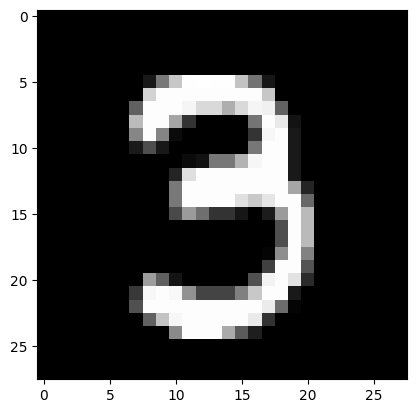

Prediction:  [5]
Label:  5


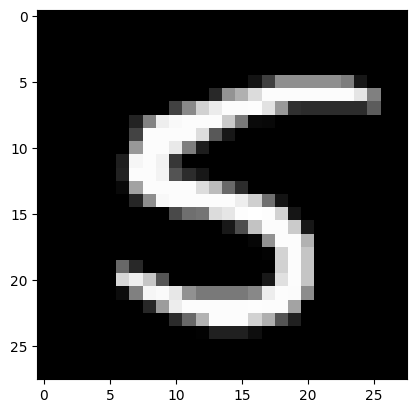

Prediction:  [0]
Label:  0


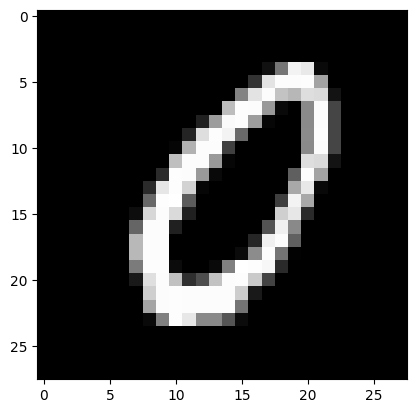

Prediction:  [8]
Label:  8


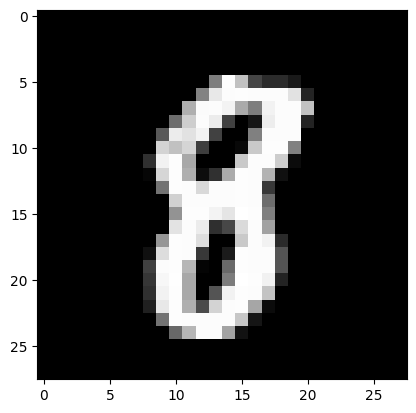

In [118]:
# test
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [119]:
# evaluate
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
print("Accuracy :", get_accuracy(dev_predictions, Y_dev))

Accuracy : 79.2


In [120]:
# confusion matrix
confusion_matrix = compute_confusion_matrix(dev_predictions, Y_dev)
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[111.   0.   2.   0.   0.   1.   0.   0.   0.   1.]
 [  0.  87.   0.   2.   0.   1.   0.   0.   0.   1.]
 [  1.   0.  78.   2.   0.   1.   3.   0.   4.   1.]
 [  0.   0.   6.  90.   0.   5.   0.   0.   8.   4.]
 [  0.   0.   2.   0.  45.   0.   2.   0.   2.  47.]
 [  3.   2.   1.  13.   0.  50.   8.   2.   8.   4.]
 [  2.   1.   2.   0.   3.   0.  82.   0.   2.   0.]
 [  0.   0.   2.   0.   2.   1.   0.  82.   0.  13.]
 [  0.   6.   8.   3.   0.   2.   1.   3.  77.   3.]
 [  1.   0.   2.   2.   0.   0.   0.  10.   2.  90.]]


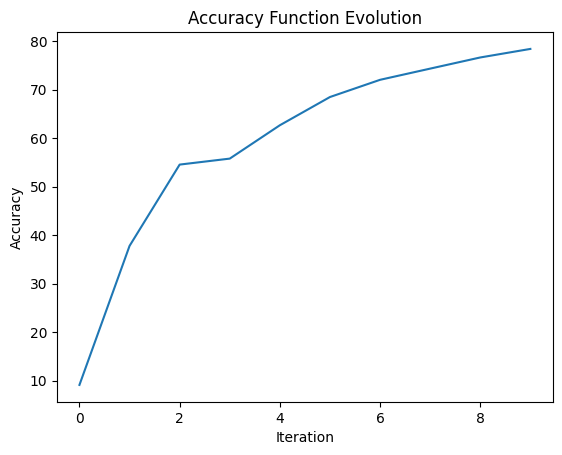

In [121]:
plt.figure()
plt.plot(range(len(accuracy_history)), accuracy_history)
plt.title('Accuracy Function Evolution')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()

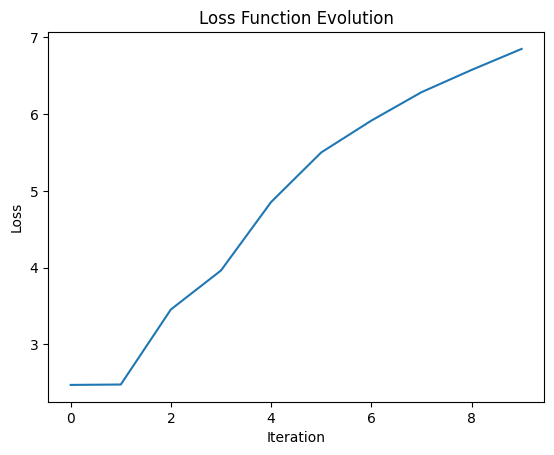

In [122]:
plt.figure()
plt.plot(range(len(loss_history)), loss_history)
plt.title('Loss Function Evolution')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

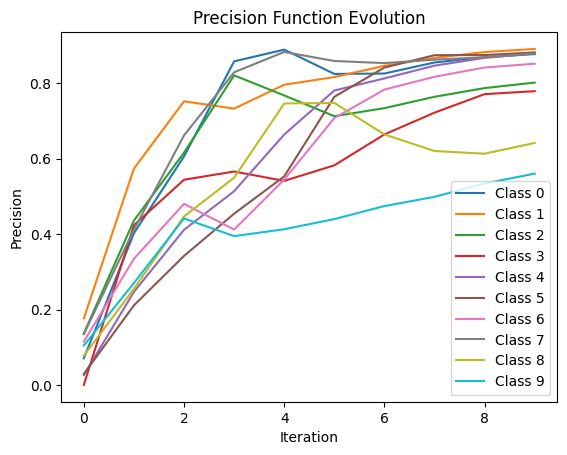

In [123]:
plt.figure()
precision_history = np.array(precision_history)
for i in range(precision_history.shape[1]):
    plt.plot(range(len(precision_history)), precision_history[:, i], label=f'Class {i}')
plt.title('Precision Function Evolution')
plt.xlabel('Iteration')
plt.ylabel('Precision')
plt.legend()
plt.show()

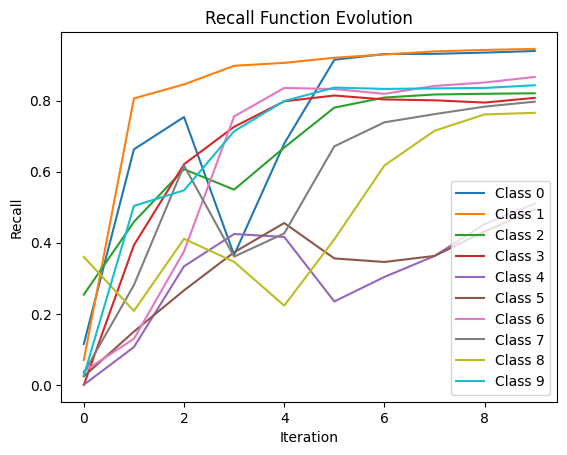

In [124]:
plt.figure()
recall_history = np.array(recall_history)
for i in range(recall_history.shape[1]):
    plt.plot(range(len(recall_history)), recall_history[:, i], label=f'Class {i}')
plt.title('Recall Function Evolution')
plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.legend()
plt.show()